In [3]:
import scanpy as sc
import numpy as np
import scvelo as scv
import anndata as ad
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from pathlib import Path
import re
from scipy.sparse import issparse
from scipy import sparse as sp

In [4]:
loom_hfd = sc.read("/gpfsdata/home/renyixiang/SRTP/DeepVelo/vgMG_HFD/velocyto/vgMG_HFD.loom")
loom_nd  = sc.read("/gpfsdata/home/renyixiang/SRTP/DeepVelo/vgMG_ND/velocyto/vgMG_ND.loom")

In [5]:
ND_anndata = sc.read_h5ad("/gpfsdata/home/renyixiang/SRTP/DeepVelo/ND_epi.h5ad")
HFD_anndata = sc.read_h5ad("/gpfsdata/home/renyixiang/SRTP/DeepVelo/HFD_epi.h5ad")

In [6]:
print("ND h5ad (head):", list(ND_anndata.obs_names[:8]))
print("ND loom  (head):", list(loom_nd.obs_names[:8]))
print("HFD h5ad (head):", list(HFD_anndata.obs_names[:8]))
print("HFD loom  (head):", list(loom_hfd.obs_names[:8]))

ND h5ad (head): ['ND_AAACCCAGTGGTTTAC-1', 'ND_AAACCCATCAGACAAA-1', 'ND_AAACGAACATCTTAGG-1', 'ND_AAACGAAGTATCACGT-1', 'ND_AAACGAATCGGCCTTT-1', 'ND_AAACGCTCATTGTCGA-1', 'ND_AAAGAACGTCTACGTA-1', 'ND_AAAGGATAGAGGCCAT-1']
ND loom  (head): [np.str_('vgMG_ND:AAACGCTAGGTATAGTx'), np.str_('vgMG_ND:AAACGCTTCGCTTACCx'), np.str_('vgMG_ND:AACAAAGAGCCACAAGx'), np.str_('vgMG_ND:AAACGAATCGGCCTTTx'), np.str_('vgMG_ND:AAAGGGCTCTCCATATx'), np.str_('vgMG_ND:AAACGCTAGTAGAGTTx'), np.str_('vgMG_ND:AAAGGATCAGGTTTACx'), np.str_('vgMG_ND:AAACGAATCTCACTCGx')]
HFD h5ad (head): ['HFD_AAACGAAAGGTTTACC-1', 'HFD_AAAGGGCAGCAGGCAT-1', 'HFD_AAAGGTATCGTTCTAT-1', 'HFD_AAAGTCCTCTACGGGC-1', 'HFD_AACAAAGGTGGTTCTA-1', 'HFD_AACAAGAAGCGTTAGG-1', 'HFD_AACAAGAGTCGAACGA-1', 'HFD_AACACACTCTAACGGT-1']
HFD loom  (head): [np.str_('vgMG_HFD:AAACGCTAGCGAGTACx'), np.str_('vgMG_HFD:AAAGGGCAGAGCACTGx'), np.str_('vgMG_HFD:AACAAAGCACTGCGTGx'), np.str_('vgMG_HFD:AAAGGGCCAGTATTCGx'), np.str_('vgMG_HFD:AAAGTGAGTGATTAGAx'), np.str_('vgMG_HFD:AAA

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scvelo as scv


def normalize_barcodes(index, keep=16):
    """Standardize cell barcodes, remove 'vgMG_ND:' prefix, remove trailing 'x' and truncate to specified length."""
    s = pd.Index(index.astype(str))
    s = s.str.replace(r'^[^:]*:', '', regex=True)  # Remove 'vgMG_ND:' or 'vgMG_HFD:' prefix
    s = s.str.replace(r'x$', '', regex=True)     # Remove trailing 'x'
    if keep is not None:
        s = s.str.slice(0, keep)                  # Truncate to the specified length (default 16)
    return s



def make_unique_on_norm(ad, keep=16):
    ad = ad.copy()
    ad.obs["barcode_raw"] = ad.obs_names.astype(str)
    ad.obs["barcode_norm"] = normalize_barcodes(ad.obs_names, keep=keep)

    if ad.n_obs != ad.obs["barcode_norm"].nunique():
        if sp.issparse(ad.X):
            totals = np.asarray(ad.X.sum(axis=1)).ravel()
        else:
            totals = ad.X.sum(axis=1)
        tmp = pd.DataFrame({
            "barcode_norm": ad.obs["barcode_norm"].values,
            "row": np.arange(ad.n_obs),
            "totals": totals
        })
        keep_rows = (
            tmp.sort_values(["barcode_norm", "totals"], ascending=[True, False])
               .drop_duplicates("barcode_norm")["row"]
               .to_numpy()
        )
        ad = ad[keep_rows].copy()

    ad.obs_names = ad.obs["barcode_norm"].astype(str)
    assert ad.obs_names.is_unique, "obs_names should be unique now"
    return ad



HFD_anndata = make_unique_on_norm(HFD_anndata, keep=16)
HFD_ldata = make_unique_on_norm(loom_hfd, keep=16)
ND_anndata = make_unique_on_norm(ND_anndata, keep=16)
ND_ldata = make_unique_on_norm(loom_nd, keep=16)

HFD_anndata = scv.utils.merge(HFD_anndata, HFD_ldata)
ND_anndata = scv.utils.merge(ND_anndata,ND_ldata)


✅ 合并完成


In [8]:
scv.pp.filter_and_normalize(ND_anndata, min_shared_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(HFD_anndata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(ND_anndata, n_pcs=30, n_neighbors=30)
scv.pp.moments(HFD_anndata, n_pcs=30, n_neighbors=30)

Filtered out 16195 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Filtered out 18132 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_101633/869910452.py:3: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(ND_anndata, n_pcs=30, n_neighbors=30)
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


/tmp/ipykernel_101633/869910452.py:4: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(HFD_anndata, n_pcs=30, n_neighbors=30)
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
scv.tl.recover_dynamics(ND_anndata,n_jobs=24)
scv.tl.velocity(ND_anndata, mode = "dynamical")

recovering dynamics (using 24/28 cores)


  0%|          | 0/1012 [00:00<?, ?gene/s]

    finished (0:01:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [10]:
scv.tl.recover_dynamics(HFD_anndata,n_jobs=24)
scv.tl.velocity(HFD_anndata, mode = "dynamical")

recovering dynamics (using 24/28 cores)


  0%|          | 0/995 [00:00<?, ?gene/s]

    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
genes = ND_anndata.var_names
cells = ND_anndata.obs_names

for layer in ["spliced", "unspliced", "ambiguous", "Ms", "Mu", "velocity"]:
    if layer in ND_anndata.layers:
        M = ND_anndata.layers[layer]
        if sp.issparse(M):
            M = M.toarray()
        ND_anndata.layers[layer] = np.asarray(M, dtype=np.float32)
        assert ND_anndata.layers[layer].shape == (len(cells), len(genes)), f"{layer} shape mismatch"


if sp.issparse(ND_anndata.X):
    ND_anndata.X = ND_anndata.X.toarray()
ND_anndata.X = np.asarray(ND_anndata.X, dtype=np.float32)
assert ND_anndata.X.shape == (len(cells), len(genes))

scv.tl.velocity_graph(ND_anndata, n_jobs=16)

computing velocity graph (using 16/28 cores)


  0%|          | 0/1391 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
genes = HFD_anndata.var_names
cells = HFD_anndata.obs_names

for layer in ["spliced", "unspliced", "ambiguous", "Ms", "Mu", "velocity"]:
    if layer in HFD_anndata.layers:
        M = HFD_anndata.layers[layer]
        if sp.issparse(M):
            M = M.toarray()
        HFD_anndata.layers[layer] = np.asarray(M, dtype=np.float32)
        assert HFD_anndata.layers[layer].shape == (len(cells), len(genes)), f"{layer} shape mismatch"

if sp.issparse(HFD_anndata.X):
    HFD_anndata.X = HFD_anndata.X.toarray()
HFD_anndata.X = np.asarray(HFD_anndata.X, dtype=np.float32)
assert HFD_anndata.X.shape == (len(cells), len(genes))

scv.tl.velocity_graph(HFD_anndata, n_jobs=16)

computing velocity graph (using 16/28 cores)


  0%|          | 0/765 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/

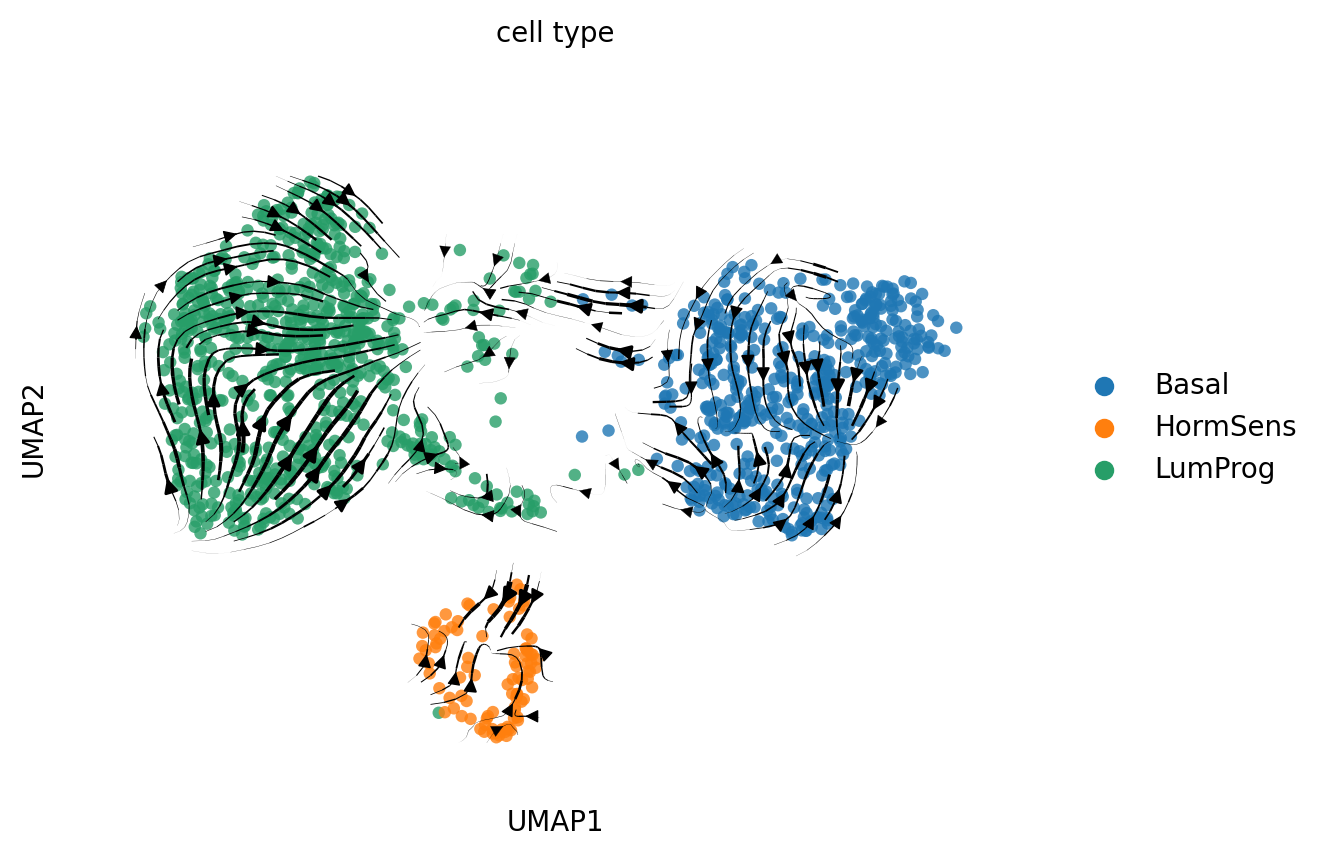

✅ 已保存到: /gpfsdata/home/renyixiang/SRTP/DeepVelo/ND_umap_velocity.png


In [ ]:
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import os

ND_anndata.obs["cell_type"] = pd.Categorical(ND_anndata.obs["cell_type"])

cats = ND_anndata.obs["cell_type"].cat.categories
palette = dict(zip(cats, sc.pl.palettes.default_20[:len(cats)]))
ND_anndata.uns["cell_type_colors"] = [palette[c] for c in cats]

umap_coords = ND_anndata.obsm['X_umap']
x_min, x_max = umap_coords[:, 0].min(), umap_coords[:, 0].max()
y_min, y_max = umap_coords[:, 1].min(), umap_coords[:, 1].max()

x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

ax = scv.pl.velocity_embedding_stream(
    ND_anndata,
    basis="umap",
    color="cell_type",
    dpi=200,
    show=False,
    xlim=(x_min - x_margin, x_max + x_margin),
    ylim=(y_min - y_margin, y_max + y_margin),
    legend_loc='right margin',
    size=80,
    alpha=0.8
)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.tick_params(direction="out")

outdir = "/gpfsdata/home/renyixiang/SRTP/DeepVelo"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "ND_umap_velocity.png")
plt.savefig(outfile, format="png", dpi=300, bbox_inches="tight")

plt.show()


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/

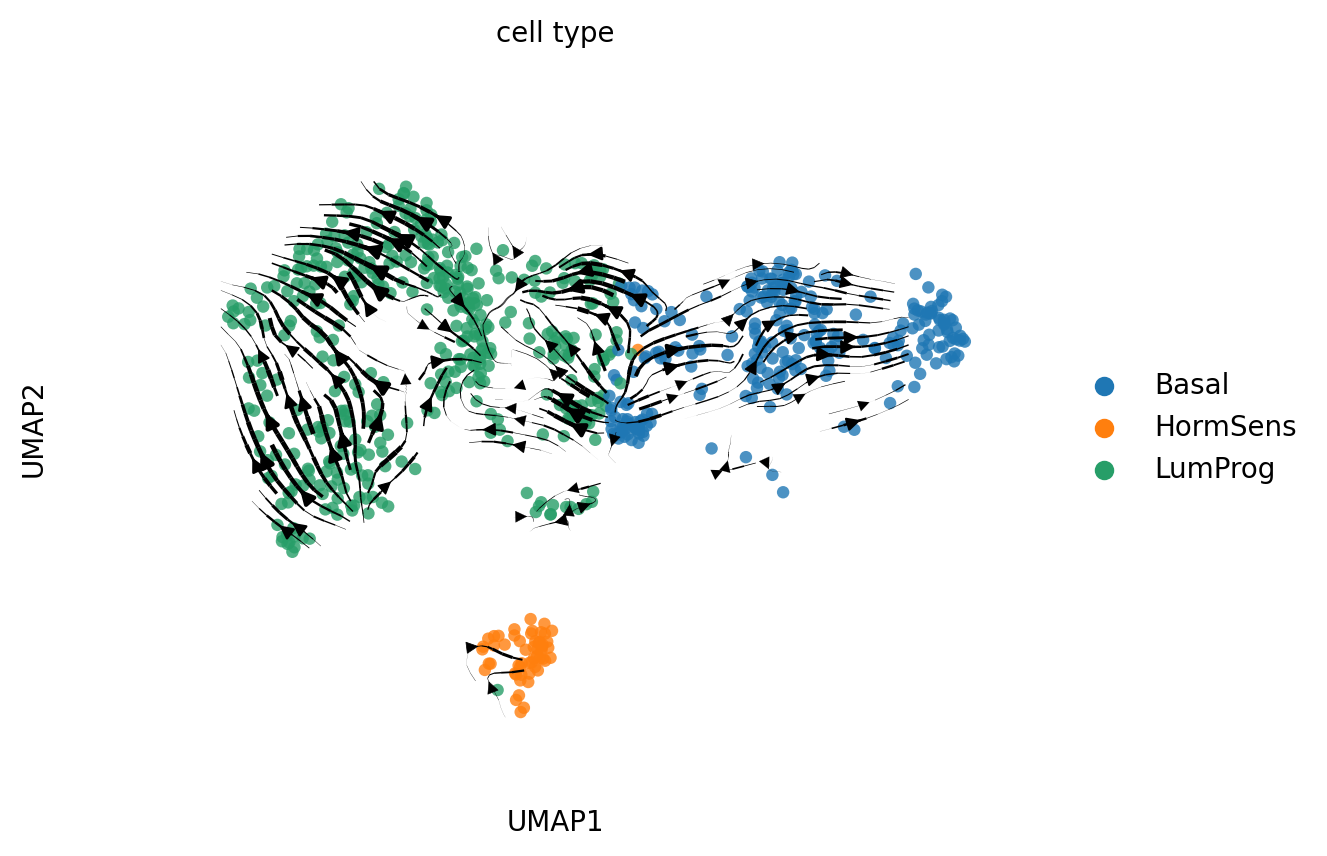

✅ 已保存到: /gpfsdata/home/renyixiang/SRTP/DeepVelo/HFD_umap_velocity.png


In [ ]:
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import os

HFD_anndata.obs["cell_type"] = pd.Categorical(HFD_anndata.obs["cell_type"])

cats = HFD_anndata.obs["cell_type"].cat.categories
palette = dict(zip(cats, sc.pl.palettes.default_20[:len(cats)]))
HFD_anndata.uns["cell_type_colors"] = [palette[c] for c in cats]

umap_coords = HFD_anndata.obsm['X_umap']
x_min, x_max = umap_coords[:, 0].min(), umap_coords[:, 0].max()
y_min, y_max = umap_coords[:, 1].min(), umap_coords[:, 1].max()

x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

ax = scv.pl.velocity_embedding_stream(
    HFD_anndata,
    basis="umap",
    color="cell_type",
    dpi=200,
    show=False,
    xlim=(x_min - x_margin, x_max + x_margin),
    ylim=(y_min - y_margin, y_max + y_margin),
    legend_loc='right margin',
    size=80,
    alpha=0.8
)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.tick_params(direction="out")

outdir = "/gpfsdata/home/renyixiang/SRTP/DeepVelo"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "HFD_umap_velocity.png")
plt.savefig(outfile, format="png", dpi=300, bbox_inches="tight")

plt.show()
